In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Image Processing with Neural Network

## Fashion-MNIST dataset 

In [2]:
###-----------------
### Import Libraries
###-----------------

import os
import numpy as np
import pandas as pd

from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from utils.helper import fn_plot_torch_hist, fn_plot_confusion_matrix

## Cuda

In [3]:
torch.cuda.is_available()

False

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## utils functions

In [5]:
print(fn_plot_torch_hist.__doc__)

None


In [6]:
print (fn_plot_confusion_matrix.__doc__)


    Args:
        y_true: Ground Truth 
        y_pred : Predictions
        labels : dictonary 
                  {0: 'Goal Keeper', 
                  1: 'Defender', 
                  2: 'Mid-Fielder', 
                  3: 'Forward'}
    
    


## basic parameters

In [7]:
###----------------------
### Some basic parameters
###----------------------

inpDir = '../..\Classwork/input'
outDir = './output'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
torch.manual_seed(RANDOM_STATE)

EPOCHS = 30 # number of epochs
ALPHA = 0.001 # learning rate
TEST_SIZE = 0.2
BATCH_SIZE = 32

# parameters for Matplotlib
params = {'legend.fontsize': 'medium',
          'figure.figsize': (15, 6),
          'axes.labelsize': 'medium',
          'axes.titlesize':'large',
          'xtick.labelsize':'medium',
          'ytick.labelsize':'medium'
         }

plt.rcParams.update(params)

CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

## Read Fashion-MNIST data set

### dataset loading and cleaning

In [8]:
trainfilepath = os.path.join(inpDir,'fashion_mnist', 'fashion-mnist_train.csv')
testfilepath = os.path.join(inpDir,'fashion_mnist', 'fashion-mnist_test.csv')

train_df = pd.read_csv(trainfilepath)
test_df = pd.read_csv(testfilepath)

train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
labels = {0: 'T-shirt/top', 
          1: 'Trouser', 
          2: 'Pullover', 
          3: 'Dress',
          4: 'Coat', 
          5: 'Sandal', 
          6: 'Shirt', 
          7: 'Sneaker', 
          8: 'Bag', 
          9: 'Ankel boot'}

##  Scalling and Features and labels extraction to tensor format 

In [10]:
class FashionDS(Dataset):

    def __init__(self, 
                 dataframe : pd.DataFrame,
                 device: str = device):
        self.df = dataframe
        self.device = device
        
        self.labels = self.df['label'].to_numpy()
        X = self.df.drop('label' , axis =1).to_numpy()
        
        self.features = X/255.  ### minmax scalling for image data
         
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self,idx):
        features = self.features[idx]
        label = self.labels[idx]
            
        features = torch.tensor(features, dtype=torch.float32,device = self.device)
        label = torch.tensor(label, dtype=torch.int64,device = self.device)
        return features, label

In [11]:
train_ds = FashionDS(train_df)
test_ds = FashionDS(test_df)

train_loader = DataLoader(train_ds, batch_size = BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_ds, batch_size = BATCH_SIZE, shuffle=True)

images, targets = next(iter(train_loader)) 
images = images.numpy()
targets = targets.numpy()
targets

array([7, 6, 4, 0, 4, 2, 8, 8, 3, 7, 3, 8, 7, 8, 3, 2, 9, 1, 9, 4, 0, 4,
       5, 1, 8, 6, 9, 5, 4, 3, 2, 6], dtype=int64)

In [12]:
images.shape

(32, 784)

## Visualisation of dataset

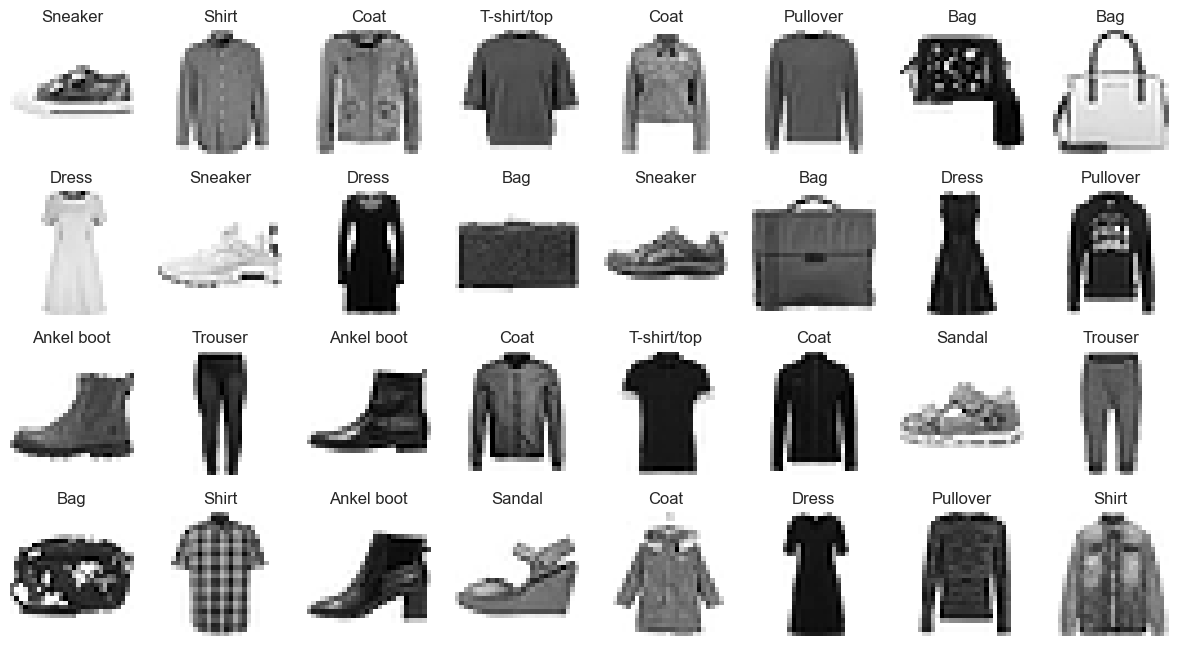

In [13]:
plt.figure(figsize=(15,8))
for i in range(BATCH_SIZE):
    plt.subplot(4,8,i+1)
    plt.imshow(images[i].reshape(28,28), cmap = plt.cm.binary) ## binary - black and whie images
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title(labels[targets[i]])

## Model

In [14]:
input_shape = train_df.shape[1]-1
input_shape

784

In [15]:
class Model (nn.Module):
    def __init__(self, input_dim):
        super(Model, self).__init__()
        
        ## define Dropout rates
        self.dor1 = 0.2
        self.dor2 = 0.2
        
        ## Layer 1
        self.layer1 = nn.Linear(input_dim,128) ## 784*128(no of weights) ratio-6
        self.activ1 = nn.Tanh()
        self.dropout1 = nn.Dropout(self.dor1)
        
        ## Layer 2
        self.layer2 = nn.Linear(128,32)## 128*32 ratio-4
        self.activ2 = nn.Tanh()
        self.dropout2 = nn.Dropout(self.dor2)
        
        ## Output layer
        self.layer3 = nn.Linear(32,10) ## 32*10 ratio-3
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self,x):
        x = self.layer1(x)
        x = self.activ1(x)
        x = self.dropout1(x)
        
        x = self.layer2(x)
        x = self.activ2(x)
        x = self.dropout2(x)
        
        x = self.layer3(x)
        return self.softmax(x)

net = Model(input_dim = input_shape).to(device)
print(net)

Model(
  (layer1): Linear(in_features=784, out_features=128, bias=True)
  (activ1): Tanh()
  (dropout1): Dropout(p=0.2, inplace=False)
  (layer2): Linear(in_features=128, out_features=32, bias=True)
  (activ2): Tanh()
  (dropout2): Dropout(p=0.2, inplace=False)
  (layer3): Linear(in_features=32, out_features=10, bias=True)
  (softmax): LogSoftmax(dim=1)
)


## Traing and testing

In [16]:
## Loss function
loss_fn = nn.CrossEntropyLoss()

## Optimizer
optimizer = torch.optim.Adam(net.parameters(),lr=ALPHA,weight_decay = 1e-4)

### Some lists to collect data
loss = []
tloss = []
n_epoch = []
acc = []
tacc = []

## iterations
for epoch in range(EPOCHS):
    
    train_loss = 0.0
    train_acc = 0.0
    
    for i, (data, target) in enumerate(train_loader):
    
        net.train() ### set model in training mode
    
        predict_prob = net(data) ## make prediction
    
        curr_loss = loss_fn(predict_prob , target) ## Calculate loss
    
        ### -----------
        ### Back Prop Step
        ### -----------
    
        optimizer.zero_grad() ### forget gradients for previous loop
        curr_loss.backward() ## asssign loss calculated
        optimizer.step() ## calculate gradients and take step to reduce loss
    
        train_loss += curr_loss.data.item()  # append to loss list
    
        _, y_pred = torch.max(predict_prob, 1) # get predicted class from the probabilities
        
        curr_acc = accuracy_score(target.numpy(), y_pred.numpy()) # move to CPU if  device = 'cpu' --> y_pred.data.cpu()
    
        train_acc += curr_acc  # append to accuracy list
        
        num_batch_train = i
    
    test_loss = 0.0
    test_acc = 0.0
    
    for i, (data, target) in enumerate(test_loader):
        
        net.eval() # evaluation mode, prevent from learning
    
        predict_prob_tst = net(data) # make predictions on test data
    
        tcurr_loss = loss_fn( predict_prob_tst, target)
    
        test_loss += tcurr_loss.data.item()  # append to loss list
    
        _, y_pred = torch.max(predict_prob_tst, 1) # get predicted class from the probabilities
    
        tcurr_acc = accuracy_score(target.numpy(), y_pred.numpy())# move to CPU 
    
        test_acc += tcurr_acc # append to accuracy list3
        
        num_batch_test = i
    
    n_epoch.append(epoch)
    loss.append(train_loss/num_batch_train)
    tloss.append(test_loss/num_batch_test)
    acc.append(train_acc/num_batch_train)
    tacc.append(test_acc/num_batch_test)  
    
    if epoch % 5 == 0:
        fmtStr = 'Epoch :{:5d}/{:5d} --- Loss: {:.5f}/{:.5f} | Acc {:.5f}/{:.5f}'
        
        print (fmtStr.format(epoch, EPOCHS,
                             train_loss/num_batch_train,
                             test_loss/num_batch_test,  
                             train_acc/num_batch_train, 
                             test_acc/num_batch_test))

Epoch :    0/   30 --- Loss: 0.58685/0.42991 | Acc 0.79963/0.84846
Epoch :    5/   30 --- Loss: 0.38784/0.35664 | Acc 0.86229/0.87680
Epoch :   10/   30 --- Loss: 0.36865/0.35999 | Acc 0.86936/0.87089
Epoch :   15/   30 --- Loss: 0.35612/0.33072 | Acc 0.87353/0.88732
Epoch :   20/   30 --- Loss: 0.35239/0.35926 | Acc 0.87328/0.87630
Epoch :   25/   30 --- Loss: 0.34624/0.33530 | Acc 0.87602/0.88291


## Visualization of model metrics

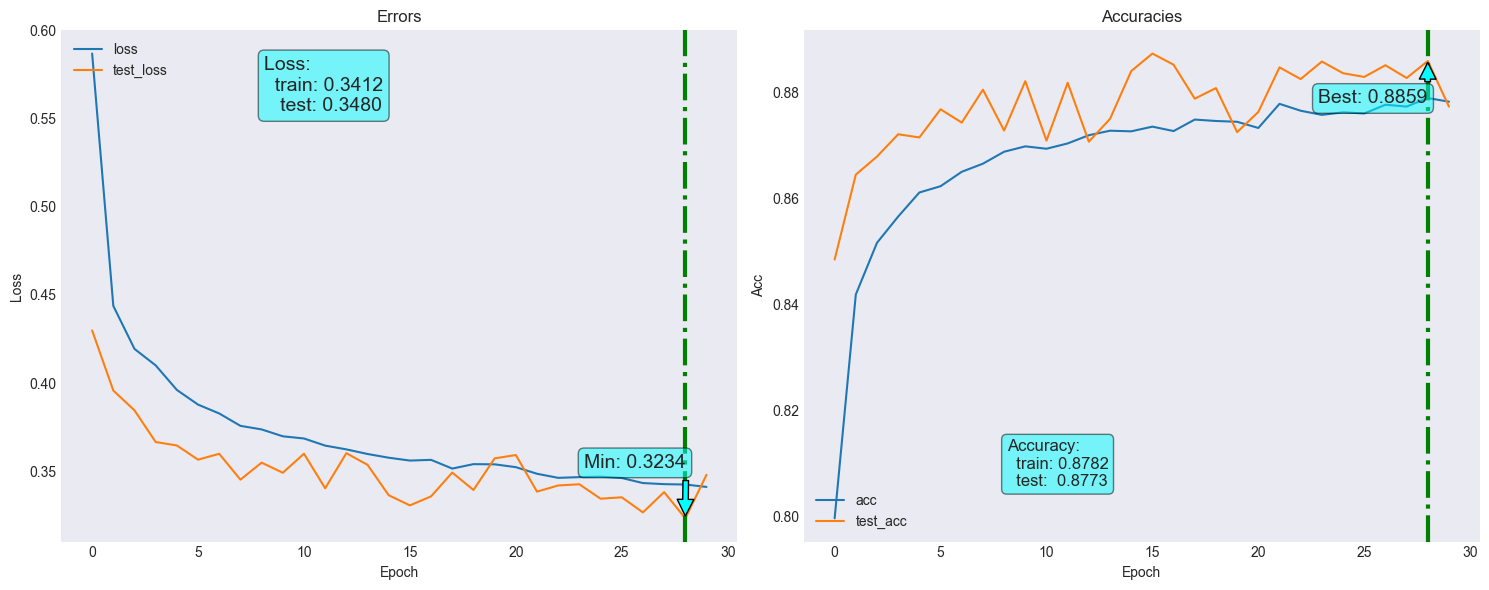

In [17]:
loss_df = pd.DataFrame({'epoch': n_epoch,
                       'loss' : loss,
                       'test_loss' : tloss,
                       'acc' : acc,
                       'test_acc': tacc})
fn_plot_torch_hist(loss_df)

## Training Confusion matrics

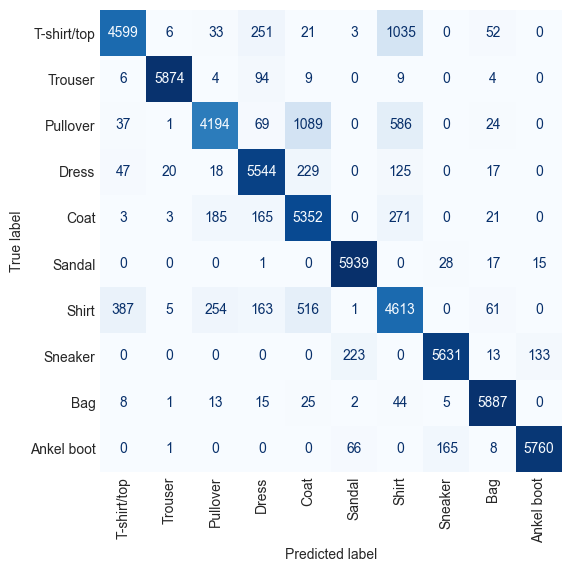

In [18]:
y_train = []
y_pred = []

for i, (data,target) in enumerate (train_loader):
    outputs = net(data)
    pred = torch.argmax(outputs, dim=1)
    y_train.extend(target.numpy())
    y_pred.extend(pred.numpy())
fn_plot_confusion_matrix(y_train, y_pred, labels=labels)

## Testing Confusion matrics

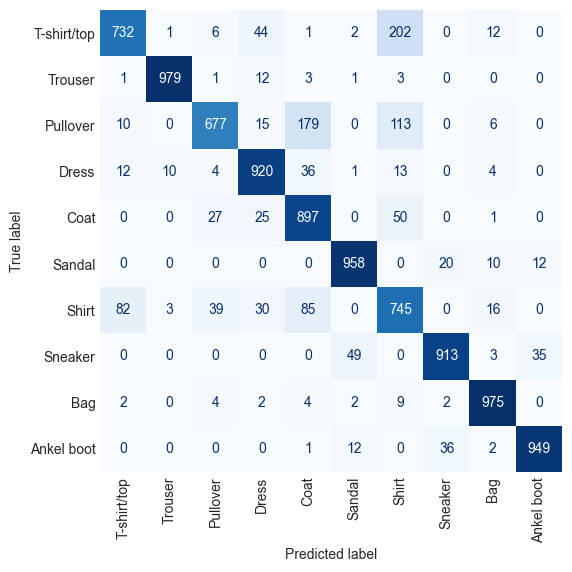

In [19]:
y_test = []
y_pred = []

for i, (data,target) in enumerate (test_loader):
    outputs = net(data)
    pred = torch.argmax(outputs, dim=1)
    y_test.extend(target.numpy())
    y_pred.extend(pred.numpy())
fn_plot_confusion_matrix(y_test, y_pred, labels=labels)

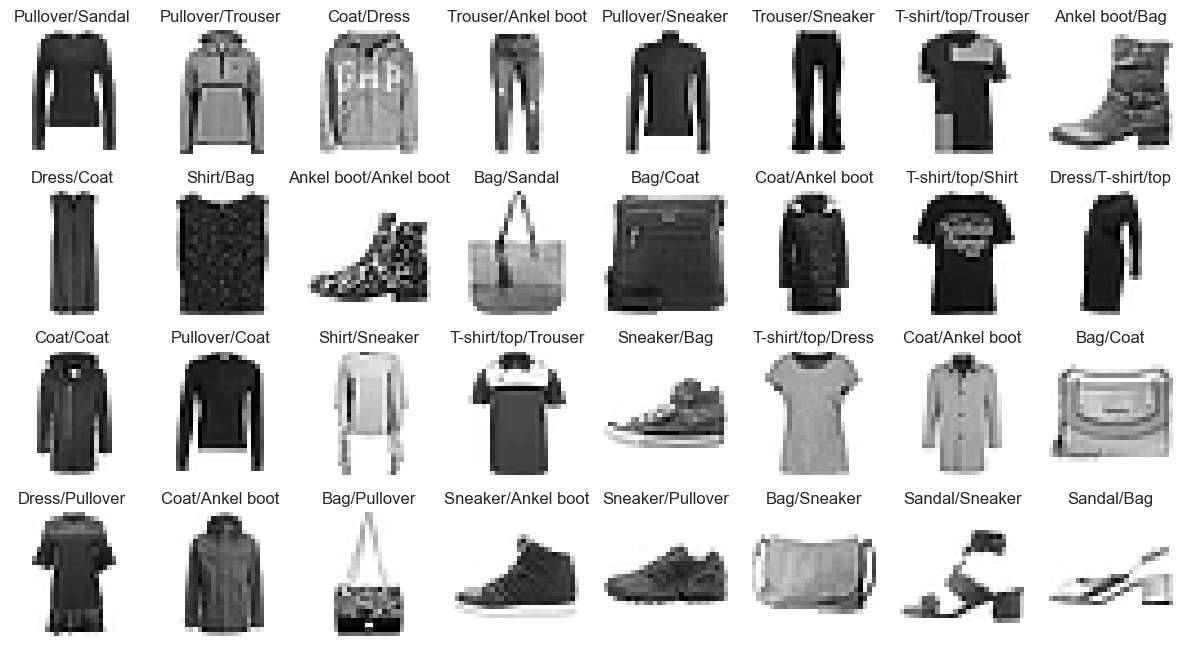

In [26]:
images, targets = next(iter(test_loader)) 

outputs = net(images)
pred = torch.argmax(outputs, dim=1)
y_test.extend(target.numpy())
y_pred.extend(pred.numpy())

images = images.numpy()
targets = targets.numpy()

plt.figure(figsize=(15,8))
for i in range(BATCH_SIZE):
    plt.subplot(4,8,i+1)
    plt.imshow(images[i].reshape(28,28), cmap = plt.cm.binary) ## binary - black and whie images
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title(labels[targets[i]]+'/'+labels[y_pred[i]])